# V. HÁZI FELADAT

Ezt a feladatsort tetszőleges nyelven meg lehet oldani. A kimeneti adatok ábrázolásához minden esetben használjuk a jupyter notebookot! Az ábrák legyenek áttekinthetőek, és szerepeljen rajtuk tengelyfelirat!

In [63]:
from glob import glob
import cv2
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
%pylab inline
from scipy import signal
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'svd', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Főkomponens-analízis

A főkomponens-analízis (angol nevén principal component analysis - PCA), más néven Karhunen-Loève-transzformáció, egy olyan lineáris eljárás, mely egy $D$ dimenziós vektorokból álló adathathalmazt egy ortogonális transzformáció - azaz $D$ dimenziós forgatás - segítségével olyan új bázisra visz át, ahol az adatvektorok közötti _kovariancia_ zérus. Az eredeti adatvektorok új bázis szerinti kifejtési együtthatóit főkomponenseknek nevezzük.

A főkomponens-analízis másképpen is megfogalmazható: Első lépésben keressük azt az irányvektort, melyre levetítve az adatvektorokat a projektált vektorok hosszának szórása maximálisnak adódik. Második lépésben levonjuk az adatvektorokból az így megtalált vektorra vett projekciót, majd az eljárást megismételjük oly módon, hogy megköveteljük, a következő irányvektor legyen merőleges az előzőleg megtaláltra. Az eljárást $D$-szer megismételve előáll a keresett bázis, melyen az adatvektorokat kifejtve meghatározhatók a főkomponensek.

Jelöljük az adatvektorokat $\mathbf{x}_1, \mathbf{x}_2, ... \mathbf{x}_N$-nel, melyek mindegyike $D$ elemű. Legyen az $\mathbf{X}$ mátrix olyan, hogy sorvektoronként tartalmazza az $\mathbf{x}_i$ adatvektorokat, azaz $N$ sora és $D$ oszlopa van:

$$
X_{ij} =
\begin{bmatrix}
    x_{11}       & x_{12} & x_{13} & \dots & x_{1D} \\
    x_{21}       & x_{22} & x_{23} & \dots & x_{2D} \\
    ... \\
    x_{N1}       & x_{N2} & x_{N3} & \dots & x_{ND}
\end{bmatrix},
$$

ahol az első index adatvektorokat, a második pedig a vektorkomponenseket indexeli.

### A kovarianciamátrix módszere

Az $X$ mátrix segítségével a főkomponensek megtalálására több ekvivalens módszert is találhatunk. Elsőként tekintsük az adatvektorok kovarianciamátrixát, melyet az $\mathbf{X}$ mátrix segítségével a következő alakban írhatunk:

$$
\mathbf{C} = \frac{1}{N}(\mathbf{X} - \mathbf{\mu})^\mathrm{T}(\mathbf{X} - \mathbf{\mu}),
$$

ahol $\mathbf{X} - \mathbf{\mu}$ úgy értelmezendő, hogy a mátrix minden sorából levonjuk az oszloponként vett átlagot. Könnyű látni, hogy a kovarianciamátrix mindig $D \times D$ méretű, tehát ha a a dimenziószám nagy, és kevés adatvektor van, azaz $D \gg N$, akkor a kovarianciamátrix előállítása nem célszerű.

### A duális főkomponens-analízis

Ha fennáll, hogy $D \gg N$, akkor érdemesebb a

$$
\tilde{\mathbf{C}} = \frac{1}{N}(\mathbf{X} - \mathbf{\mu})(\mathbf{X} - \mathbf{\mu})^\mathrm{T}
$$

mátrixot tekinteni, melyről belátható, hogy sajátértékei megegyeznek $\mathbf{C}$ nem zérus sajátértékeivel, a sajátvektoraira pedig fennáll, hogy

$$
\mathbf{v_i} = \frac{1}{\sqrt{N\lambda_i}} (\mathbf{X} - \mathbf{\mu}) \tilde{\mathbf{v}}_i.
$$

Ez utóbbi kifejezés úgy ellenőrizhető, felírjuk a duális problémában szereplő $(\mathbf{X} - \mathbf{\mu})(\mathbf{X} - \mathbf{\mu})^\mathrm{T}$ mátrix sajátérték-egyenletét, majd balról megszorozzuk $(\mathbf{X} - \mathbf{\mu})$-vel.

### Főkomponens-analízis szingulárisérték-dekompozícióval

A szingulárisérték-dekompozíció (singular value decomposition - SVD) során egy tetszőleges $N \times M$ alakú mátrixot a következő módon faktorizálunk:

$$
\mathbf{X} = \mathbf{U} \mathbf{S} \mathbf{V}^\mathrm{T},
$$

ahol az $\mathbf{S}$ mátrix diagonális, és főátlójában az ún. szinguláris értékeket tartalmazza, $\mathbf{V}^\mathrm{T}$ oszlopaiban a jobboldali szinguláris vektorok, $\mathbf{U}$ soraiban pedig a baloldali szinguláris vektorok jelennek meg. A szinguláris értékek száma $K = \min(M, N)$, $\mathbf{U}$ és $\mathbf{V}^\mathrm{T}$ pedig általában $N \times N$ és $M \times M$ alakú mátrixok. Belátható, hogy

* az $\mathbf{U}$ baloldali szinguláris vektorok azonosak az $\mathbf{X}\mathbf{X}^\mathrm{T}$ mátrix ortonormált sajátvektoraival
* a $\mathbf{V}$ jobboldali szinguláris vektorok azonosak az $\mathbf{X}^\mathrm{T}\mathbf{X}$ mátrix ortonormált sajátvektoraival
* a nem zérus szinguláris értékek azonosak $\mathbf{X}\mathbf{X}^\mathrm{T}$ és $\mathbf{X}^\mathrm{T}\mathbf{X}$ nem zérus sajátértékeivel

Ezek figyelembe vételével a főkomponens-analízis közvetlenül SVD segítségével is elvégezhető, tekintve, hogy

$$
\mathbf{X}^\mathrm{T}\mathbf{X} = 
  (\mathbf{V} \mathbf{S}^\mathrm{T} \mathbf{U}^\mathrm{T})(\mathbf{U} \mathbf{S} \mathbf{V}^\mathrm{T}) = 
  \mathbf{V} \mathbf{S}^\mathrm{T} (\mathbf{U}^\mathrm{T} \mathbf{U}) \mathbf{S} \mathbf{V}^\mathrm{T} =
  \mathbf{V} \mathbf{S}^\mathrm{T} \mathbf{S} \mathbf{V}^\mathrm{T} =
  \mathbf{V} \mathbf{S}^2 \mathbf{V}^\mathrm{T}.
$$

A szingulárisérték-dekompozíció megvalósítására léteznek hatékony algoritmusok, így a kovarianciamátrix előállítása általában nem célszerű, de ha mégis szükséges, akkor többnyire a sajátérték-probléma megoldására is SVD-t használunk.

### A főkomponensek meghatározása

Fejtsük ki az eredeti adatvektorokat a kovarianciamátrix sajátvektorai által definiált bázison, azaz határozzuk meg az adatvektorok főkomponenseit! Ehhez elegendő belátni, hogy a főkomponensek előállnak a következő alakban:

$$
\mathbf{PC} = (\mathbf{X} - \mathbf{\mu}) \mathbf{V},
$$

ahol $\mathbf{V}$ a normált sajátvektorokból, mint oszlopvektorokból alkotott mátrix.

### Dimenzióredukció főkomponens-analízis segítségével

A kovarianciamátrix sajátértékei azt adják meg, hogy a nekik megfelelő sajátvektorokkal kijelölt irányokban mekkora az adatvektorok szórása. Belátható, hogy ha csak a néhány legnagyobb sajátértékhez tartozó sajátvektort, illetve főkomponenst tartjuk meg, akkor az adatvektoroknak egy olyan projekciójához jutunk, mely számot ad az adatokban rejlő variancia nagy részéről, viszont figyelmen hagyja azokat az irányokat, melyekben inkább csak zaj látható. Emiatt a főkomponensanalízis egy hatékony lineáris adattömörítési, illetve zajszűrési eljárás is.

Ha a nagy dimenziószám nem indokolja, akkor a legnagyobb sajátértékek előállításához célszerű az SVD-n alapuló módszert alkalmazni, ugyanis az SVD-algoritmusok eleve nagyság szerint csökkenő sorrendben adják vissza a szinguláris értékeket. Ilyenkor a főkomponenseket nem az teljes sajátbázisra számítjuk ki, hanem csak az első $k$ legnagyobb szinguláris értékhez tartozó szinguláris vektort tartjuk meg a $\mathbf{V}$ mátrixból, és így végezzük el a korábbi kifejtést:

$$
\mathbf{PC}^{(k)} = (\mathbf{X} - \mathbf{\mu}) \mathbf{V}^{(k)},
$$

# Feladatok

## 1. feladat - Főkomponens-analízis két dimenzióban

Az alábbi függvény egy fent definiált alakú $\mathbf{X}$ mátrixot hoz létre. Ábrázoljuk a mátrixban tárolt adatvektorokat egy grafikonon pontok segítségével. Az ábrázoláskor állítsuk a grafikon vízszintes és függőleges méretét, valamint a tengelyek értéktartományát azonosra, hogy a különböző irányú szórások jól láthatók legyenek. Próbáljuk meg szemmel megállapítani, hogy mik lehetnek azok az irányok, melyekre levetítve az adatpontokat maximális lesz a projekciók hosszának szórása.

In [64]:
def gen_rand(N):
    mu = 6 * np.random.rand(2) - 3.0
    t = np.pi * np.random.rand()
    R = np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])
    sig = 2 * np.random.rand()
    C = np.diag([sig, sig + 3 * np.random.rand()])
    C = np.dot(R, np.dot(C, np.linalg.inv(R)))
    X = np.random.multivariate_normal(mu, C, N)
    return X

Számítsuk ki az adatvektorok kovarianciamátrixát, majd oldjuk meg a kovarianciamátrix sajátérték-problémáját! Készítsünk egy ábrát, melyen az $\mathbf{X}$ mátrixban szereplő adatpontokra rárajzoljuk a kovarianciamátrix sajátvektorait oly módon, hogy a sajátvektorok hossza egyezzen meg a hozzájuk tartozó sajátértékkel! Ügyeljünk a sajátvektorok normálására, és arra hogy a sajátvektorokat a ponthalmaz súlypontjából kiindulva kell ábrázolni!

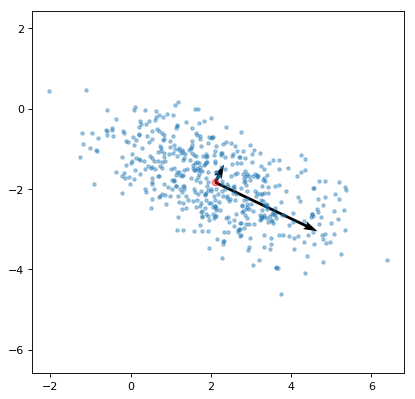

In [424]:
genrand = gen_rand(500)
genrand0 = genrand[:,0]
genrand1 = genrand[:,1]
covariancia = cov(genrand[:,0],genrand[:,1])
ertek,vektor=eig(covariancia)
v1=vektor[:,0]
v2=vektor[:,1]
v1_norm= v1 *(abs(ertek[0]))
v2_norm=v2 *(abs(ertek[1]))
f=genrand.mean(axis=0)
V = np.array([v1_norm,v2_norm])
origin = f[0], f[1]

figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
plot(genrand0,genrand1, '.',alpha=0.4)
quiver(*origin,V[:,0],V[:,1], angles= 'xy', scale=8)
plot(f[0],f[1],'ro',alpha=0.4)
#xlim(-7,7)
#ylim(-7,7)
axis('equal');

pca_y = np.dot(genrand, vektor)

#https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.quiver.html

# Kifejtve az új bázison

[[1.00000000e+00 1.78279928e-16]
 [0.00000000e+00 1.00000000e+00]]


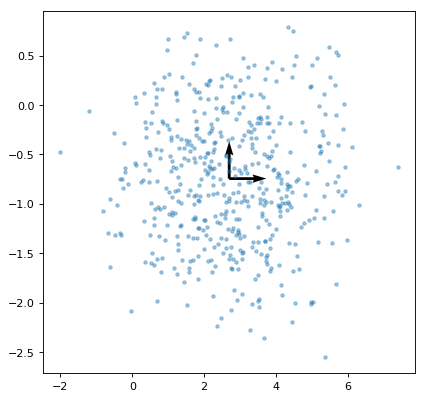

In [425]:
cov1 = cov(pca_y[:,0],pca_y[:,1])
ert1,vek1 = eig(cov1)
k_átl=pca_y.mean(axis=0)
figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
origin = k_átl[0],k_átl[1]
plot(pca_y[:,0],pca_y[:,1],'.', alpha=0.4)
quiver(*origin,vek1[0],vek1[1],scale = 10)
print(vek1)

 Határozzuk meg, és ábrázoljuk az adatvektorok főkomponenseit azonos osztásközű skálák mellett! Mit figyelhetünk meg?

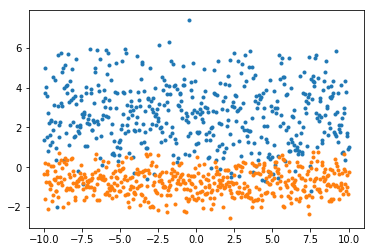

In [426]:
plot(t,pca_y[:,0],'.')
plot(t,pca_y[:,1],'.')

Oldjuk meg az előző feladatot most a kovarianciamátrix meghatározása helyett közvetlenül szingulárisérték-dekompozícióval! Hogyan kaphatjuk vissza az SVD eredményéből a kovarianciamátrix sajátértékeit?

In [427]:
from numpy import array
from scipy.linalg import svd

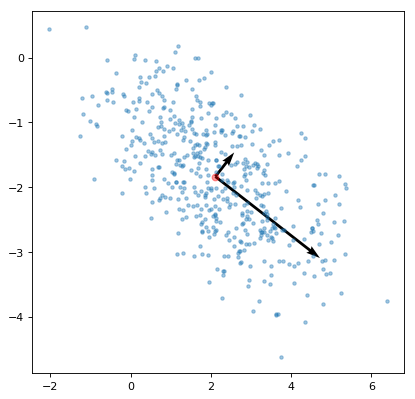

In [432]:
U, s, VT = svd(genrand, full_matrices=False)
#VT = -1*(VT)
#s = transpose(s)
vtper0 = VT[0]*abs(s[0])*-1
vtper1 = VT[1]*abs(s[1])
f=genrand.mean(axis=0)
figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
V = array([vtper0,vtper1])
origin = f[0], f[1]
plot(genrand0,genrand1, '.',alpha=0.4)
quiver(*origin,V[:,0],V[:,1],scale=200)
plot(f[0],f[1],'ro',alpha=0.4)

[[ 0.97680607  0.2141259 ]
 [-0.2141259   0.97680607]]


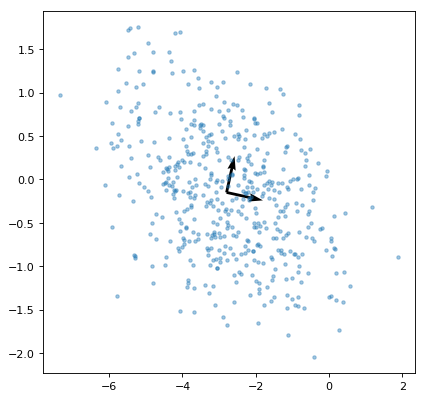

In [433]:
svd_y = np.dot(U,diag(s))
cov2 = cov(svd_y[:,0],svd_y[:,1])
ert2,vek2 = eig(cov2)
svd_átl=svd_y.mean(axis=0)
figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
origin = svd_átl[0],svd_átl[1]
plot(svd_y[:,0],svd_y[:,1],'.', alpha=0.4)
quiver(*origin,vek2[0],vek2[1],scale = 10)
print(vek2)


In [434]:
def svd(X):
  # Data matrix X, X doesn't need to be 0-centered
  n, m = X.shape
  # Compute full SVD
  U, Sigma, Vh = np.linalg.svd(X, 
      full_matrices=False, # It's not necessary to compute the full matrix of U or V
      compute_uv=True)
  # Transform X with SVD components
  X_svd = np.dot(U, np.diag(Sigma))
  return X_svd, U, Sigma, Vh

In [435]:
a = svd(genrand)[0]
b = svd(genrand)[1]
c = svd(genrand)[2] #eigvalue
d = svd(genrand)[3] #eigvec
e = d*sqrt(c)
e = -1*(e)
#print((a))

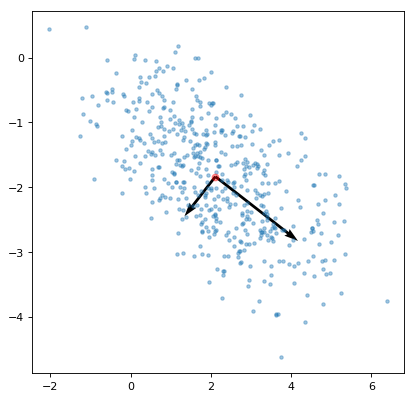

In [436]:
f=genrand.mean(axis=0)
figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
V = array([vtper0,vtper1])
origin = f[0], f[1] # origin point
plot(genrand0,genrand1, '.',alpha=0.4)
#xis('equal');
quiver(*origin,e[0],e[1],scale=30)
plot(f[0],f[1],'ro',alpha=0.4)

[[ 0.97680607  0.2141259 ]
 [-0.2141259   0.97680607]]


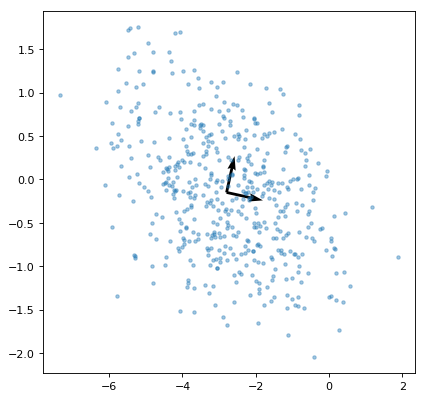

In [437]:
svd_y = a#np.dot(genrand,diag(s))
cov2 = cov(svd_y[:,0],svd_y[:,1])
ert2,vek2 = eig(cov2)
svd_átl=svd_y.mean(axis=0)
figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
origin = svd_átl[0],svd_átl[1]
plot(svd_y[:,0],svd_y[:,1],'.', alpha=0.4)
quiver(*origin,vek2[0],vek2[1],scale = 10)
print(vek2)

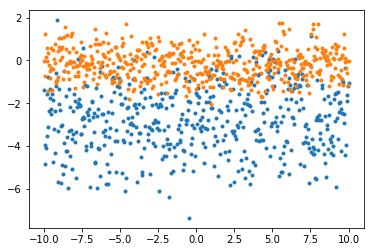

In [439]:
plot(t,svd_y[:,0],'.')
plot(t,svd_y[:,1],'.')

In [440]:
#X = P D Q^t, ellenörzés
X_a = U @ diag(s) @ VT
print(np.std(genrand), np.std(X_a), np.std(genrand - X_a))
print(VT*s)

2.3086001685461177 2.3086001685461173 3.891958102445461e-16
[[-56.21644084  10.1150549 ]
 [ 43.79083078  12.98519291]]


## 2. feladat - Sajátarcok meghatározása

Az alábbi függvény az évfolyam hallgatóiról készült fényképeket tölti be egy `numpy` adattömbbe. Az adattömb indexei a következők:

* 1: A fénykép sorszáma 0-tól
* 2: A fényképek sorainak száma (290)
* 3: A fényképek oszlopainak száma (220)

A szürkeárnyalatos fényképek úgy ábrázolódnak a számítógépben, hogy minden pixelhez egy 0 és 255 közötti egész szám tartozik (uint8 adattípus). A 0 érték fekete pixelt, a 255 fehéret, a köztes értékek pedig egy lineáris skálán a szürke különböző árnyalatait jelentik. A képek megjelenítás a `matplotlib` `imshow` parancsa használható, az alábbi példák szerint.

A feladat, hogy alakítsük át a képeket adatvektorrá (például a `reshape`, `flatten` vagy `ravel` függvény segítségével), majd végezzük el az adatvektorok főkomponens-analízisét, azaz határozzuk meg azt a bázist, melyen a képekből készített adatvektorok korrelálatlanok. Mivel jelen esetben a $D = 290 \cdot 220 = 63800$ dimenziószám jóval nagyobb, mint $N$, a képek száma, ezért a bevezetőben említett lehetőségek közül csak a duális-PCA jöhet szóba.

Miután meghatároztuk a sajátvektorokat (sajátarcokat)

* ábrázoljuk a sajátértékeket csökkenő sorrendben, a sorszámuk függvényében
* keressük meg azt a legkisebb sajátértéket, ami még kilógónak tekinthető
* alakítsuk vissza a sajátvektorokat képpé, és ábrázoljuk a nagy sajátértékekhez tartozó sajátvektorokat

Ezek után készítsük el a sajátvektorokból készült csonkolt bázist, majd határozzuk meg az egyes arcokhoz tartozó főkomponenseket. Készítsük el az arcok csonkolt bázison történő rekonstrukcióját. Hány sajátvektor megtartása szükséges ahhoz, hogy az arcok felismerhetőek legyenek?

Próbáljunk meg egy olyan arcot kifejteni a kapott bázison, melyet nem használtunk fel a bázis meghatározásához.

In [16]:
def load_pics():
    files = glob('data/*.bmp')
    img = cv2.imread(files[0])
    imgs = np.empty((len(files), img.shape[0], img.shape[1]), dtype=np.uint8)
    for i in range(0, len(files)):
        imgs[i,:,:] = cv2.imread(files[i])[:,:,0]
    return imgs

In [17]:
imgs = load_pics()
imgs.shape

(102, 290, 220)

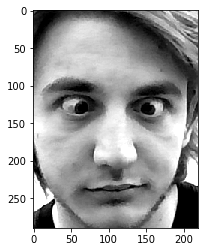

In [18]:
plt.imshow(imgs[40], cmap='gray')